In [1]:
# !pip install tsfresh

In [2]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
# import os
# os.kill(os.getpid(), 9)

In [3]:
pwd

'/aiffel/aiffel/aiffel_quest/mini_quest_240228'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
file_path = os.getenv('HOME') + '/aiffel/aiffel_quest/mini_quest_240228'

passengers_data = pd.read_csv(file_path + '/AirPassengers.csv')
passengers_data.drop(columns='Month',inplace=True)
passengers_data

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


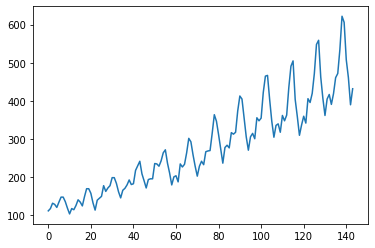

In [6]:
plt.figure()
plt.plot(passengers_data)
plt.show()

### 분산을 일정하게 만들기
#### log transformation

In [7]:
log_transformed = np.log(passengers_data) # 분산을 일정하게 하기 위해 log

In [8]:
log_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


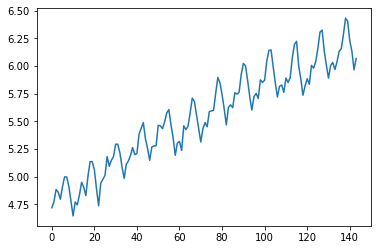

In [9]:
# 로그변환 된 그래프
plt.figure()
plt.plot(log_transformed)
plt.show()

### 차분을 통해 추세 제거

In [10]:
diffed = log_transformed.diff()[1:] 
# diff() 사용하면 간단하게 차분 구할 수 있음 # 첫번째는 차수를 구할 수 없기 때문에 1부터

In [11]:
diffed

,#Passengers
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
5,0.109484
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


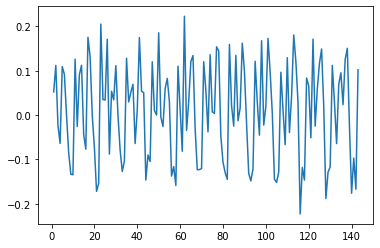

In [12]:
# 차분 제거한 데이터를 그려봄
# 커지는 분산과 증가하는 추세를 제거한 데이터를 얻을 수 있음
plt.figure()
plt.plot(diffed)
plt.show()

## (추가) 계절 차분을 통해 계절성 제거하기
#### airpassnegers 데이터는 12개월을 주기로 하는 계절성이 포함
#### 이런 경우엔 계절 차분을 통해서 계절성을 데이터에서 제거
    

In [13]:
seasonally_diffed = diffed.diff(12) # diff에 12라는 값을 넣어주면 12로 하는 계절 차분을 수행

In [14]:
seasonally_diffed

,#Passengers
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


In [15]:
seasonally_diffed.dropna(inplace=True) #차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거
seasonally_diffed

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


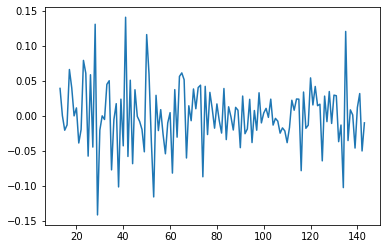

In [16]:
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

### 검정을 통해 정상성 확인하기

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옴
    print('ADF statistics')
    print(stat) # ADF 검정 통계입니다.
    print('P-value')
    print(p_value) # P-value

In [19]:
adf_test(seasonally_diffed)

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


유의수준 0.01에서 단위근이 존재한다라는 귀무가설을 기각하고 시계열은 정상적이다라는 대립가설을 채택

## 시계열 분류

#### Logistic Regression을 이용한 시계열 분류가 낮은 score 보였음
#### 앙상블 모델과 더 많은 특징을 활용해서 분류 성능을 높여보자

In [20]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

In [21]:
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [22]:
timeseries

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [23]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [25]:
def custom_classification_split(x,y,test_size=0.3):
    
    num_true = int(y.sum() * test_size)
    num_false = int((len(y)- y.sum())* test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)]
    X_test = timeseries[timeseries['id'].isin(id_list)]
    
    return X_train,  y_train, X_test, y_test

In [26]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

#### EfficientParameters는 큰 계산이 필요한 calculator를 제외하고 가능한 모든 특징을 생성

In [27]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
settings = EfficientFCParameters()
from tsfresh.utilities.dataframe_functions import impute

In [28]:
comprehensive_features_train = extract_features(
X_train, column_id='id', column_sort='time',
default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 402/402 [00:17<00:00, 23.47it/s]


In [29]:
comprehensive_features_test = extract_features(
X_test, column_id='id', column_sort='time',
default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 126/126 [00:05<00:00, 23.88it/s]


#### impute를 통해 간단히 데이터를 전처리

In [30]:
impute(comprehensive_features_train)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [31]:
impute(comprehensive_features_test)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


#### Random Forest 모델


In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=3)

In [33]:
rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [36]:
rf_clf.score(comprehensive_features_test, y_test)

0.9523809523809523

#### XGBoost

In [38]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators=10, max_depth=3)

In [39]:
xgb_clf.fit(comprehensive_features_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:53:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
xgb_clf.score(comprehensive_features_test, y_test)

1.0

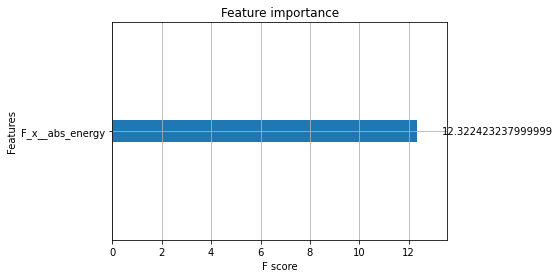

In [41]:
xgb.plot_importance(xgb_clf, importance_type='gain')
# * "weight" is the number of times a feature appears in a tree
# * "gain" is the average gain of splits which use the feature
# * "cover" is the average coverage of splits which use the feature
# where coverage is defined as the number of samples affected by the split
plt.show()

In [43]:
sum(xgb_clf.feature_importances_ != 0) # Fx값 의 abs_energy특징만 유의미함

1

#### 결국 고장 유무를 판별하는 기준은 F_X__abs_energy라는 특징 하나

In [44]:
from sklearn.metrics import classification_report

In [82]:
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

dail-min-temperatures로 통계적 지표 확인

In [53]:
tp = pd.read_csv('~/aiffel/time_series/data/daily-min-temperatures.csv')

tp.drop(columns='Date',inplace=True)
tp

,Temp
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8
...,...
3645,14.0
3646,13.6
3647,13.5
3648,15.7


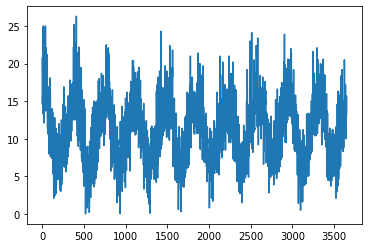

In [54]:
plt.figure()
plt.plot(tp)
plt.show()

In [56]:
# 로그 변환
tf_tp = np.log(tp)
tf_tp

,Temp
0,3.030134
1,2.884801
2,2.933857
3,2.681022
4,2.760010
...,...
3645,2.639057
3646,2.610070
3647,2.602690
3648,2.753661


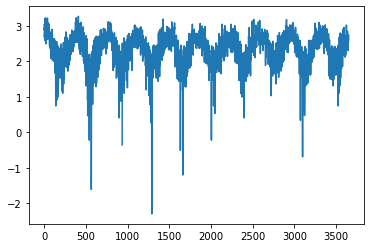

In [57]:
plt.figure()
plt.plot(tf_tp)
plt.show()

In [58]:
## 차분제거
df_tf_tp = tf_tp.diff()[1:]
df_tf_tp

,Temp
1,-0.145333
2,0.049056
3,-0.252835
4,0.078988
5,0.000000
...,...
3645,-0.041964
3646,-0.028988
3647,-0.007380
3648,0.150971


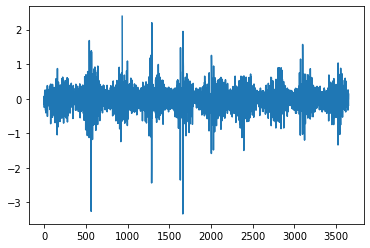

In [60]:
plt.figure()
plt.plot(df_tf_tp)
plt.show()

In [61]:
## 계절성 제거
seasonally_diffed = df_tf_tp.diff(12) # diff에 12라는 값을 넣어주면 12로 하는 계절 차분을 수행
seasonally_diffed

,Temp
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
3645,-0.111490
3646,-0.043803
3647,-0.029199
3648,-0.062050


In [63]:
seasonally_diffed.dropna(inplace=True)
seasonally_diffed

,Temp
13,0.397977
14,0.101767
15,0.064093
16,-0.083831
17,0.185553
...,...
3645,-0.111490
3646,-0.043803
3647,-0.029199
3648,-0.062050


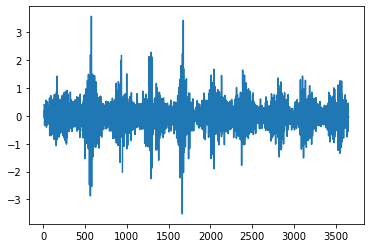

In [65]:
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

In [66]:
## ADF 검정
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옴
    print('ADF statistics')
    print(stat) # ADF 검정 통계입니다.
    print('P-value')
    print(p_value) # P-value

In [73]:
seasonally_diffed.replace([np.inf, -np.inf], np.nan, inplace=True)

In [77]:
seasonally_diffed.interpolate(method='linear', inplace=True)


In [78]:
adf_test(seasonally_diffed)

ADF statistics
-21.48165800656064
P-value
0.0


유의수준 0.01에서 단위근이 존재한다라는 귀무가설을 기각하고 시계열은 정상적이다라는 대립가설을 채택

#### 회고
- 시계열 강의에서 알려주는대로 했지만 시계열에 대해서 감이 오지 않는다.
- daily-temperatures를 추가적으로 하여 통계적 지표 ADF와 P-value 확인하는 연습을 좀 더 해보았는데 해석하는데 어려웠다.
- 시계열 분류 모델 3가지를 daily - temperatures 사용해보고 못한게 아쉬웠다.
- 시계열도 더 공부하면 재미있을 것 같다.